In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import copy
eq = importr('malariaEquilibrium')
r_default_params = eq.load_parameter_set()
ages = ro.FloatVector(range(100))

In [3]:
import torch
import pyro
from pyro.infer import MCMC, NUTS
import pyro.distributions as dist
import arviz as az

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
def single_prev_inc(params, eir):
    r_params = copy.deepcopy(r_default_params)
    for n, p in zip(['kb', 'ub', 'b0', 'b1', 'IB0'], params):
        r_params.rx2[n] = ro.FloatVector([p])
    states = eq.human_equilibrium(eir, ft = 0., p=r_params, age=ages)
    two_ten = ro.IntVector(range(4,11))
    u5 = ro.IntVector(range(6))
    return (
        sum(states.rx2['states'].rx(two_ten,'pos_M')) / sum(states.rx2['states'].rx(two_ten,'prop')),
        sum(states.rx2['states'].rx(u5,'inc')) / sum(states.rx2['states'].rx(u5,'prop'))
    )

In [78]:
#experiments = 10
kb = np.random.gamma(4., 1.)
ub = np.random.lognormal(1., 1.)
b0 = np.random.beta(7., 1.)
b1 = np.random.beta(1., 7.)
IB0 = np.random.gamma(5., .1)

In [79]:
population = 1000
EIR = 21.

In [88]:
obs_prev, obs_inc = [v * population for v in single_prev_inc([kb, ub, b0, b1, IB0], EIR)]

In [84]:
def model_prev_r(kb, ub, b0, b1, IB0, eir):
    params = [kb, ub, b0, b1, IB0]
    return single_prev_inc(params, ro.FloatVector([eir]))

In [85]:
model_prev_r(kb, ub, b0, b1, IB0, EIR)

(0.35309025217910284, 0.0018692763007226148)

In [86]:
def model():
    kb = pyro.sample('kb', dist.Gamma(4., 1.))
    ub = pyro.sample('ub', dist.LogNormal(1., 1.))
    b0 = pyro.sample('b0', dist.Beta(7., 1.))
    b1 = pyro.sample('b1', dist.Beta(1., 10.))
    IB0 = pyro.sample('IB0', dist.Gamma(5., .1))
    pred_prev, pred_inc  = model_prev_r(kb, ub, b0, b1, IB0, EIR)
    model_prev = pyro.sample('obs_prev', dist.Binomial(population, pred_prev))
    model_inc = pyro.sample('obs_inc', dist.Binomial(population, pred_inc))

In [89]:
conditioned = pyro.condition(
    model,
    data={
        'obs_prev': torch.as_tensor(obs_prev),
        'obs_inc': torch.as_tensor(obs_inc)
    }
)

In [90]:
n_samples = 100
n_warmup = 100
n_chains = 1

nuts_kernel = NUTS(conditioned, jit_compile=False)
mcmc = MCMC(
    nuts_kernel,
    num_samples=n_samples,
    warmup_steps=n_warmup,
    num_chains=n_chains,
)
mcmc.run()
mcmc.summary(prob=0.7)

Sample: 100%|███████████████████████████████████████| 200/200 [6:53:34, 124.07s/it, step size=3.33e-04, acc. prob=0.639]                                                          



                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     11.19      0.86     11.10     10.01     11.78     30.26      1.01
        b0      0.99      0.00      0.99      0.99      0.99      3.09      1.75
        b1      0.03      0.00      0.03      0.03      0.03      5.86      1.09
        kb      4.74      0.26      4.74      4.47      5.04      6.65      1.11
        ub      3.60      0.32      3.58      3.20      3.76      3.89      1.61

Number of divergences: 0


In [92]:
IB0, b0, b1, kb, ub

(0.3721140594058803,
 0.9037856994872098,
 0.17662303461215925,
 6.689927185011362,
 4.076327704526687)

In [ ]:
model = load_model('./models/eq/')

In [11]:
prob_prev_r(*[tf.reshape(x, 1) for x in [kb, ub, b0, b1, IB0]], EIR)#.sample(100)#.log_prob(observations)

Tensor("Rank:0", shape=(), dtype=int32)
Tensor("kb:0", shape=(1,), dtype=float32)
False


AttributeError: in user code:

    File "/tmp/ipykernel_41924/2195820947.py", line 42, in prob_prev_r  *
        prev_pred = model_prev_r(kb, ub, b0, b1, IB0, eir)
    File "/tmp/ipykernel_41924/2195820947.py", line 26, in model_prev_r  *
        batch_params.rx2[n] = ro.FloatVector([p[b].numpy()])

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [341]:
*prior_samples, prior_predictive = joint_dist.sample(1000).values()

In [112]:
prior_trace = az.from_dict(
    observed_data={"observations": observations},
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    coords={"observation": np.arange(1)},
    dims={"observations": ["observation"]},
)
print(prior_trace.prior_predictive)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/data/base.py:130: UserWarning: In variable observations, there are more dims (1) given than exist (0). Passed array should have shape (chain,draw, *shape)
  warnings.warn(


ValueError: different number of dimensions on data and dims: 2 vs 3

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


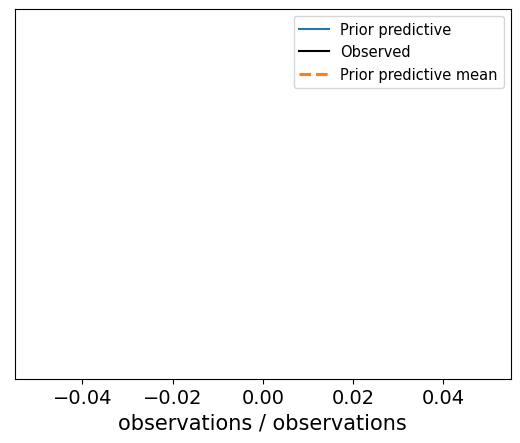

In [35]:
ax = az.plot_ppc(prior_trace, group="prior", num_pp_samples=500)

In [ ]:
#raise Error()
cols = 4
rows = (len(prior) // cols + 1)
prior_keys = list(prior.keys())
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 5, 5))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(prior_keys):
            ax = axes[r][c]
            k = prior_keys[cols * r + c]
            ax.hist(prior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            elif k == 'prev':
                ax.vlines(prev_sample * pop_sample, 0, ax.get_ylim()[1], color='orange')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

In [342]:
num_chains = 10

observed_prev = tf.constant(np.round(observations), dtype=tf.float32)
pinned_joint_dist = joint_dist.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())
parameter_names = pinned_joint_dist._flat_resolve_names()

In [332]:
initial_state

[<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1.6524005, 6.6767035, 3.9020717, 2.363007 , 2.65188  , 5.773552 ,
        2.8396187, 3.435889 , 2.6339202, 2.4859276], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 1.5428318 , 14.17975   ,  1.3790416 ,  1.0438291 , 14.429172  ,
         4.2360106 ,  2.870634  ,  0.61587214, 12.199425  ,  3.0787044 ],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.9863565 , 0.90384257, 0.7918483 , 0.90917915, 0.99929285,
        0.9242804 , 0.7055024 , 0.8466863 , 0.99761283, 0.9579491 ],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.10815747, 0.12472989, 0.06049071, 0.00844199, 0.01040475,
        0.01080648, 0.08326396, 0.00186275, 0.04911602, 0.08296055],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([48.252544, 59.85953 , 35.443504, 89.05382 , 23.908604, 64.4147  ,
        24.994259, 84.034134, 96.70047 , 90.38689

In [333]:
joint_dist.sample_distributions()#['prev'].log_prob(observed_prev)

(OrderedDict([('kb',
               <tfp.distributions.Gamma 'Gamma' batch_shape=[] event_shape=[] dtype=float32>),
              ('ub',
               <tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>),
              ('b0',
               <tfp.distributions.Beta 'Beta' batch_shape=[] event_shape=[] dtype=float32>),
              ('b1',
               <tfp.distributions.Beta 'Beta' batch_shape=[] event_shape=[] dtype=float32>),
              ('IB0',
               <tfp.distributions.Gamma 'Gamma' batch_shape=[] event_shape=[] dtype=float32>),
              ('prev',
               <tfp.distributions.Independent 'IndependentBinomial_1' batch_shape=[] event_shape=[1] dtype=float32>)]),
 OrderedDict([('kb', <tf.Tensor: shape=(), dtype=float32, numpy=3.0273254>),
              ('ub', <tf.Tensor: shape=(), dtype=float32, numpy=11.331771>),
              ('b0', <tf.Tensor: shape=(), dtype=float32, numpy=0.7301903>),
              ('b1', <tf.Tensor: shape=()

In [323]:
tf.rank(initial_state[0])

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [336]:
observations

617.4278035051792

In [339]:
joint_dist.log_prob(*initial_state, observed_prev)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-141.58543, -146.83408, -142.0173 , -142.29375, -143.99443,
       -142.81967, -143.67859, -142.45801, -145.62178, -143.35938],
      dtype=float32)>

In [335]:
joint_dist.sample(value=dict(zip(parameter_names, initial_state)))

OrderedDict([('kb',
              <tf.Tensor: shape=(10,), dtype=float32, numpy=
              array([1.6524005, 6.6767035, 3.9020717, 2.363007 , 2.65188  , 5.773552 ,
                     2.8396187, 3.435889 , 2.6339202, 2.4859276], dtype=float32)>),
             ('ub',
              <tf.Tensor: shape=(10,), dtype=float32, numpy=
              array([ 1.5428318 , 14.17975   ,  1.3790416 ,  1.0438291 , 14.429172  ,
                      4.2360106 ,  2.870634  ,  0.61587214, 12.199425  ,  3.0787044 ],
                    dtype=float32)>),
             ('b0',
              <tf.Tensor: shape=(10,), dtype=float32, numpy=
              array([0.9863565 , 0.90384257, 0.7918483 , 0.90917915, 0.99929285,
                     0.9242804 , 0.7055024 , 0.8466863 , 0.99761283, 0.9579491 ],
                    dtype=float32)>),
             ('b1',
              <tf.Tensor: shape=(10,), dtype=float32, numpy=
              array([0.10815747, 0.12472989, 0.06049071, 0.00844199, 0.01040475,
            

In [183]:
pinned_joint_dist.experimental_default_event_space_bijector().bijectors

(<tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>)

In [347]:
%%time

# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 10 #int(1e3)
num_burnin_steps = 0 #100 #int(1e3)

initial_step_size = [
    tf.constant(1e-1, shape=[num_chains] + [1] * (len(x.shape) - 1))
    for x in initial_state
]

def log_prob(*state):
    #print(state)
    #print(pinned_joint_dist.unnormalized_log_prob(state))
    return pinned_joint_dist.unnormalized_log_prob(state)

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob,
            num_leapfrog_steps=50,
            step_size=initial_step_size
        ),
        num_adaptation_steps=int((num_burnin_steps + num_results) * 0.8)#int(num_burnin_steps * 0.8)
    ),
    pinned_joint_dist.experimental_default_event_space_bijector().bijectors
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

ValueError: tf.enable_eager_execution must be called at program startup.

In [160]:
acceptance.numpy().mean()

0.43

In [161]:
parameter_names = pinned_joint_dist._flat_resolve_names()

In [162]:
posterior_predictive = tf.concat([
    list(joint_dist.sample(value=dict(zip(parameter_names, [s[:,chain,...] for s in samples]))).values())[-1][tf.newaxis, ..., tf.newaxis]
    for chain in range(num_chains)
], 0)

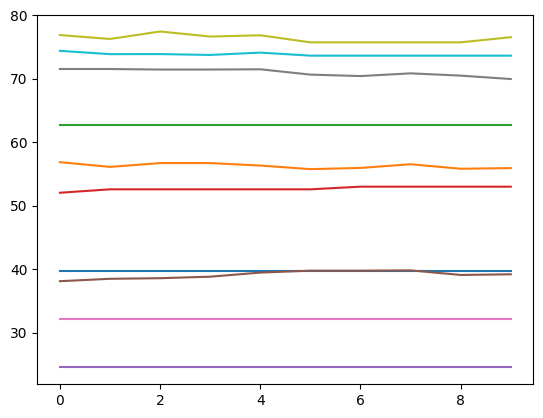

In [163]:
plt.plot(samples[4].numpy())

In [139]:
trace = az.from_dict(
    prior={k: v[tf.newaxis, ...] for k, v in zip(parameter_names, prior_samples)},
    posterior={
        k: np.swapaxes(v, 0, 1) for k, v in zip(parameter_names, samples)
    },
    prior_predictive={"observations": prior_predictive[tf.newaxis, ..., tf.newaxis]},
    posterior_predictive={"observations": posterior_predictive},
    coords={"observation": np.arange(1), "param": np.arange(len(parameter_names))},
    observed_data={"observations": observations},
    dims={"observations": ["observation"], "coefficients": ["param"]},
)

print(trace)

Inference data with groups:
	> posterior
	> posterior_predictive
	> prior
	> prior_predictive
	> observed_data


In [140]:
print(az.summary(trace).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_mean", "r_hat"]))

       mean  hdi_3%  hdi_97%  r_hat
kb    3.527   1.772    8.455  13.90
ub    4.963   0.530   15.647   9.59
b0    0.775   0.363    0.968  11.95
b1    0.109   0.002    0.309   7.65
IB0  52.794  24.533   77.101   9.34


/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


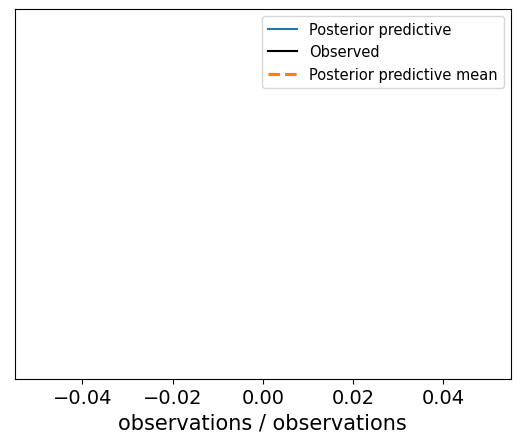

In [131]:
ax = az.plot_ppc(trace, group="posterior", num_pp_samples=500)

In [241]:
parameter_names

['kb', 'ub', 'b0', 'b1', 'IB0', 'EIR']

In [133]:
list(zip(parameter_names, (kb, ub, b0, b1, IB0, EIR), [s[0] for s in samples]))

[('kb',
  <tf.Tensor: shape=(), dtype=float32, numpy=4.6902084>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([2.509315 , 2.5031536, 8.551048 , 2.4811943, 2.2027519, 1.8013968,
         5.202758 , 2.3787286, 4.9323535, 2.9886708], dtype=float32)>),
 ('ub',
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1084418>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([ 0.52950865,  3.5829368 ,  0.9978519 ,  2.2641191 , 12.526403  ,
          2.9804716 ,  0.6570149 ,  6.4014115 ,  2.9591532 , 14.742636  ],
        dtype=float32)>),
 ('b0',
  <tf.Tensor: shape=(), dtype=float32, numpy=0.94373465>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([0.36255133, 0.7116377 , 0.668255  , 0.9481476 , 0.8446323 ,
         0.86815774, 0.7313274 , 0.8505621 , 0.9664638 , 0.85049057],
        dtype=float32)>),
 ('b1',
  <tf.Tensor: shape=(), dtype=float32, numpy=0.06142622>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([0.09473993, 0.22706854, 0.05912058, 0.00182148

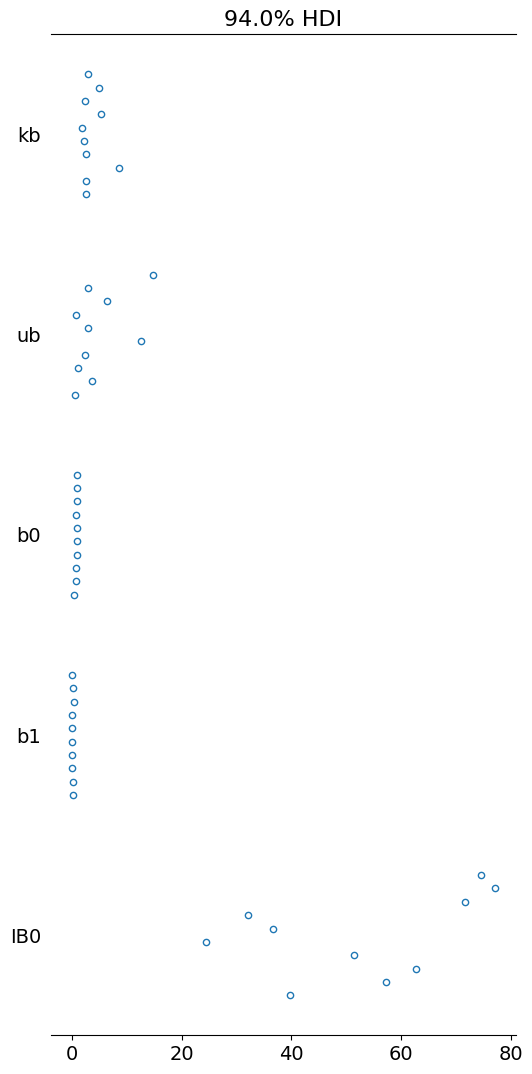

In [134]:
axs = az.plot_forest(trace, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/gc

OverflowError: cannot convert float infinity to integer

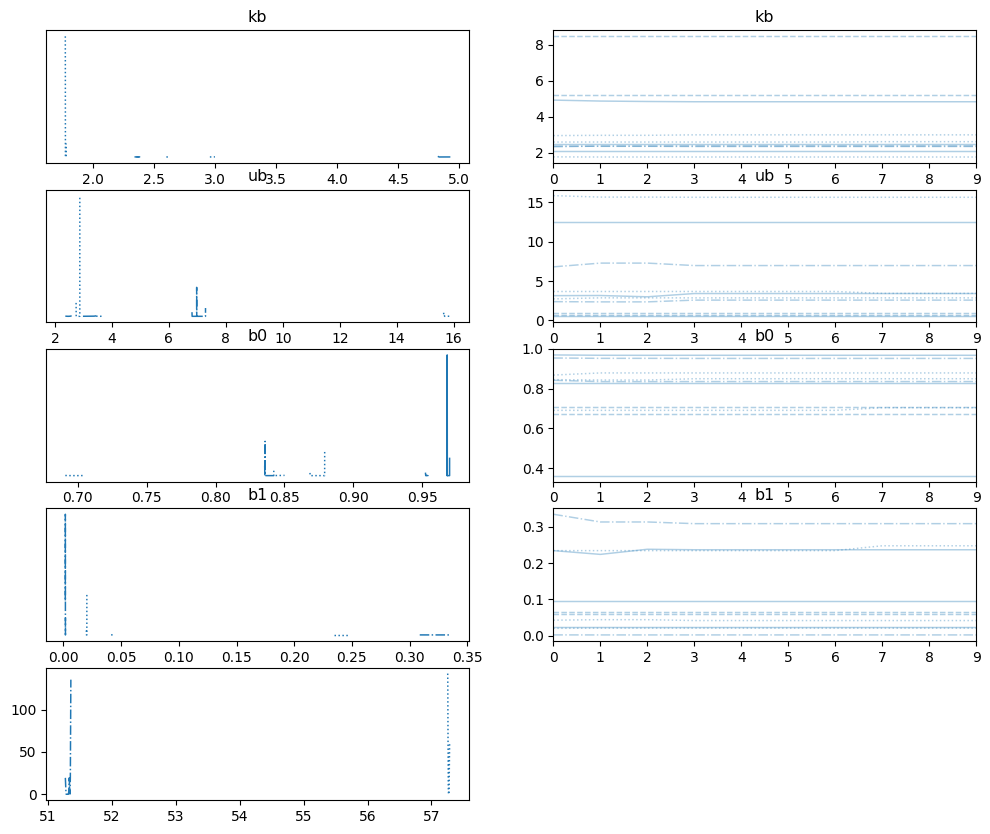

In [141]:
axs = az.plot_trace(trace, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

In [ ]:
posterior = dict(zip(initial_state_dict.keys(), samples))

In [ ]:
cols = 4
rows = (len(posterior) // cols + 1)
posterior_keys = list(posterior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 5, 5))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(posterior_keys):
            ax = axes[r][c]
            k = posterior_keys[cols * r + c]
            ax.hist(posterior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

In [ ]:
variable = 0
cols = 4
rows = (num_chains // cols + 1)
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 15, 15))
for c in range(cols):
    for r in range(rows):
        if len(axes.shape) == 1:
            ax = axes[c]
        else:
            ax = axes[r][c]
        i = cols * r + c
        if i < num_chains:
            ax.plot(samples[variable][:, i:i + 1], color='red')
        else:
            fig.delaxes(ax)

In [ ]:
plt.hist(tfp.mcmc.potential_scale_reduction(samples), bins=20)

In [ ]:
tfp.mcmc.potential_scale_reduction(samples)

In [219]:
p = model_prev_r(kb, ub, b0, b1, IB0, tf.constant(EIR))

AttributeError: 'numpy.float32' object has no attribute 'numpy'

In [220]:
tf.constant(EIR).numpy()

21.0

In [204]:
tf.reshape(kb, (1))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.6902084], dtype=float32)>

In [200]:
kb.shape[0]

IndexError: tuple index out of range

In [195]:
EIR

<tf.Tensor: shape=(), dtype=float32, numpy=21.0>

In [ ]:
ub

In [ ]:
joint_dist_r = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        kb = tfd.Gamma(4., 1., validate_args=True),
        ub = tfd.LogNormal(1., 1., validate_args=True),
        b0 = tfd.Beta(7., 1., validate_args=True),
        b1 = tfd.Beta(1., 7., validate_args=True),
        IB0 = tfd.Gamma(5., .1, validate_args=True),
        EIR = tfd.Independent(tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1),
        prev = lambda kb, ub, b0, b1, IB0, EIR : prob_prev_r(kb, ub, b0, b1, IB0, EIR)
    )
)

In [ ]:
*prior_samples, prior_predictive = joint_dist_r.sample(1000).values()

In [ ]:
prior_trace_r = az.from_dict(
    observed_data={"observations": pop_sample * prev_sample},
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    coords={"observation": np.arange(sample_size)},
    dims={"observations": ["observation"]},
)
print(prior_trace.prior_predictive)

In [ ]:
ax = az.plot_ppc(prior_trace_r, group="prior", num_pp_samples=500)

In [ ]:
%%time
# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 100 #int(1e3)
num_burnin_steps = 100 #int(1e3)

num_chains = 10

pinned_joint_dist_r = joint_dist_r.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist_r.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())

initial_step_size = [
    tf.constant(1e-3, shape=[num_chains] + [1] * (len(x.shape) - 1))
    for x in initial_state
]

def log_prob_r(*state):
    return pinned_joint_dist_r.unnormalized_log_prob(state)

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob_r,
            num_leapfrog_steps=50,
            step_size=initial_step_size
        ),
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    ),
    pinned_joint_dist_r.experimental_default_event_space_bijector().bijectors
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

In [ ]:
samples